In [2]:
# Set up

%load_ext autoreload
%autoreload 2

import torch
import random
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_device, get_act_name
import numpy as np
import matplotlib.pyplot as plt

from attribution_methods import integrated_gradients, activation_patching, highlight_components
from testing import Task, TaskDataset, logit_diff_metric, identify_outliers, average_correlation, measure_overlap, test_single_ablated_performance, test_multi_ablated_performance
from plotting import plot_attn, plot_attn_comparison, plot_correlation, plot_correlation_comparison, plot_bar_chart

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ig_mlp = torch.load("results/aligned/ioi/ig_mlp.pt")
ig_attn = torch.load("results/aligned/ioi/ig_attn.pt")

ap_mlp = torch.load("results/aligned/ioi/ap_mlp.pt")
ap_attn = torch.load("results/aligned/ioi/ap_attn.pt")

In [224]:
mlp_outlier_iso = torch.load("results/disagreements/mlp_outlier_isolated_ablation_scores.pt")
attn_outlier_iso = torch.load("results/disagreements/attn_outlier_isolated_ablation_scores.pt")

In [230]:
mlp_outlier_iso_scores = torch.tensor([v for d in mlp_outlier_iso for v in d.values()])
avg_mlp_outlier_iso_score = mlp_outlier_iso_scores.mean()
std_mlp_outlier_iso_score = mlp_outlier_iso_scores.std()
print(f"Average MLP outlier isolated ablation score: {avg_mlp_outlier_iso_score:.4f} ± {std_mlp_outlier_iso_score:.4f}")

Average MLP outlier isolated ablation score: 0.6070 ± 0.1894


In [51]:
attn_outlier_iso_scores = torch.tensor([v for d in attn_outlier_iso for v in d.values()])
avg_attn_outlier_iso_score = attn_outlier_iso_scores.mean()
std_attn_outlier_iso_score = attn_outlier_iso_scores.std()
print(f"Average attn outlier isolated ablation score: {avg_attn_outlier_iso_score:.4f} ± {std_attn_outlier_iso_score:.4f}")

Average attn outlier isolated ablation score: 0.2423 ± 0.3730


### IGNORE

In [ ]:
# Calculate average absolute attribution scores
mlp_outlier_ap_scores = {}

for sample, sample_mlp_outlier_iso in mlp_outlier_iso.items():
    for (layer, idx), score in sample_mlp_outlier_iso.items():
        if (layer, idx) not in mlp_outlier_ap_scores:
            mlp_outlier_ap_scores[(layer, idx)] = torch.zeros_like(ap_mlp[0, layer, idx])
        mlp_outlier_ap_scores[(layer, idx)] += torch.abs(ap_mlp[0, layer, idx])

for (layer, idx) in mlp_outlier_iso.keys():
    mlp_outlier_ap_scores[(layer, idx)] = ap_mlp[0, layer, idx]

n_mlp_outliers = len(mlp_outlier_iso)

# For now, one sample only
xs = torch.ones((1, n_mlp_outliers))
ys = torch.ones((1, n_mlp_outliers))

for i, ((layer, idx), score) in enumerate(mlp_outlier_iso.items()):
    xs[0, i] = mlp_outlier_ap_scores[(layer, idx)]
    ys[0, i] = score.item()

plot_correlation(
    xs,
    ys,
    x_label="Activation patching attribution score",
    y_label="Model performance under isolated ablation",
    title="Activation patching attribution scores versus isolated ablation performance for exclusive neurons",
)

AttributeError: 'list' object has no attribute 'keys'

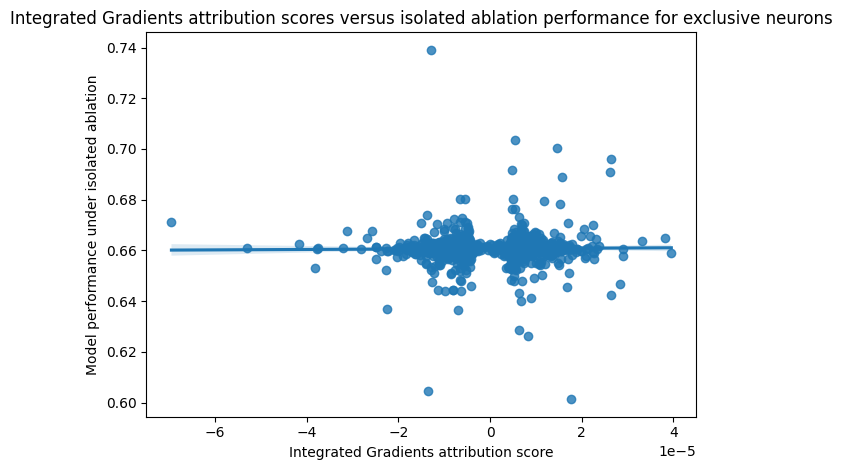

Correlation coefficient: 0.017030091231588242


In [61]:
# Calculate average absolute attribution scores
mlp_outlier_ig_scores = {}

for (layer, idx) in mlp_outlier_iso.keys():
    mlp_outlier_ig_scores[(layer, idx)] = ig_mlp[0, layer, idx]

n_mlp_outliers = len(mlp_outlier_iso)

# For now, one sample only
xs = torch.ones((1, n_mlp_outliers))
ys = torch.ones((1, n_mlp_outliers))

for i, ((layer, idx), score) in enumerate(mlp_outlier_iso.items()):
    xs[0, i] = mlp_outlier_ig_scores[(layer, idx)]
    ys[0, i] = score.item()

plot_correlation(
    xs,
    ys,
    x_label="Integrated Gradients attribution score",
    y_label="Model performance under isolated ablation",
    title="Integrated Gradients attribution scores versus isolated ablation performance for exclusive neurons",
)

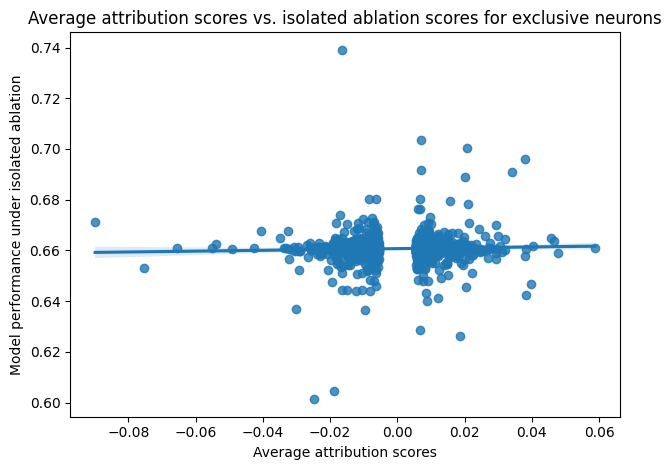

Correlation coefficient: 0.045335963338861106


In [63]:
# Calculate average absolute attribution scores
mlp_average_absolute_scores = {}

for (layer, idx) in mlp_outlier_iso.keys():
    ig_score = ig_mlp[0, layer, idx]
    ap_score = ap_mlp[0, layer, idx]
    avg_absolute_score = (ig_score + ap_score) / 2
    mlp_average_absolute_scores[(layer, idx)] = avg_absolute_score.item()

n_mlp_outliers = len(mlp_outlier_iso)

# For now, one sample only
xs = torch.ones((1, n_mlp_outliers))
ys = torch.ones((1, n_mlp_outliers))

for i, ((layer, idx), score) in enumerate(mlp_outlier_iso.items()):
    xs[0, i] = mlp_average_absolute_scores[(layer, idx)]
    ys[0, i] = score.item()

plot_correlation(
    xs,
    ys,
    x_label="Average attribution scores",
    y_label="Model performance under isolated ablation",
    title="Average attribution scores vs. isolated ablation scores for exclusive neurons",
)

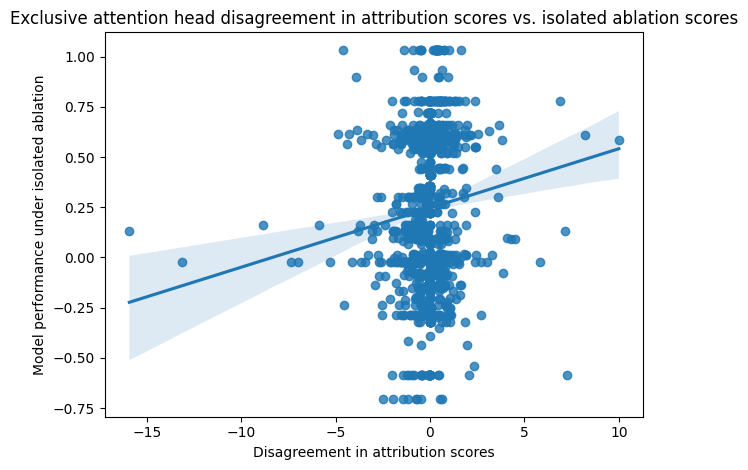

Correlation coefficient: 0.09870634893870354


In [71]:
attn_diff_scores = {}

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        diff = ap_score - ig_score
        attn_diff_scores[(s, layer, idx)] = diff.item()

xs = []
ys = []

for (sample, layer, idx), score in attn_diff_scores.items():
    xs.append(score)
    ys.append(attn_outlier_iso[sample][(layer, idx)])

xs = torch.tensor(xs).unsqueeze(0)
ys = torch.tensor(ys).unsqueeze(0)

plot_correlation(
    xs,
    ys,
    x_label="Disagreement in attribution scores",
    y_label="Model performance under isolated ablation",
    title="Exclusive attention head disagreement in attribution scores vs. isolated ablation scores",
)

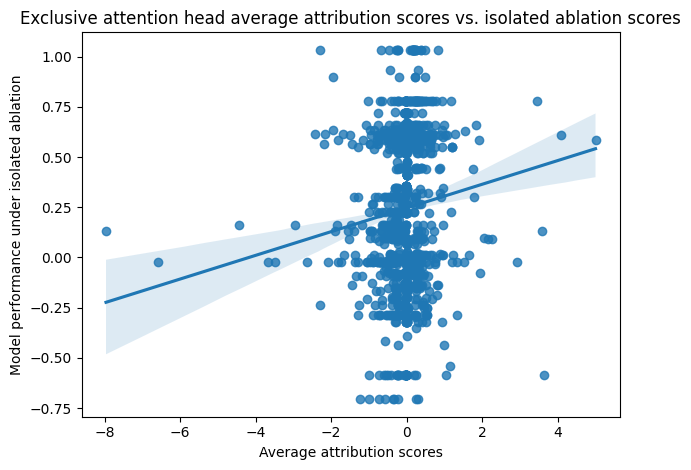

Correlation coefficient: 0.09872015962807701


In [70]:
attn_average_attribution_scores = {}

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        average = (ig_score + ap_score) / 2
        attn_average_attribution_scores[(s, layer, idx)] = average.item()

xs = []
ys = []

for (sample, layer, idx), score in attn_average_attribution_scores.items():
    xs.append(score)
    ys.append(attn_outlier_iso[sample][(layer, idx)])

xs = torch.tensor(xs).unsqueeze(0)
ys = torch.tensor(ys).unsqueeze(0)

plot_correlation(
    xs,
    ys,
    x_label="Average attribution scores",
    y_label="Model performance under isolated ablation",
    title="Exclusive attention head average attribution scores vs. isolated ablation scores",
)

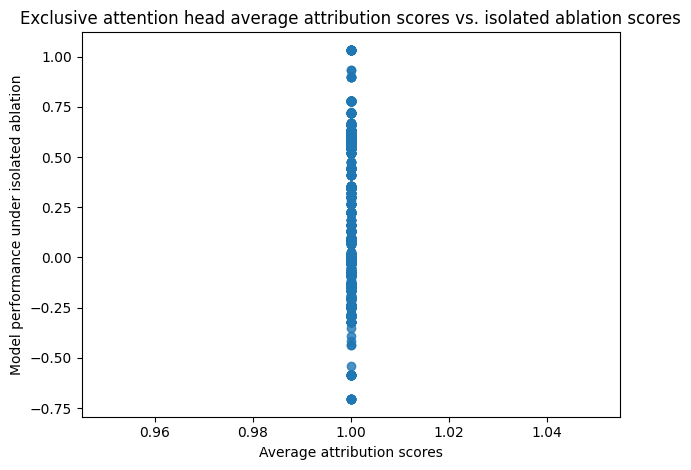

Correlation coefficient: nan


/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [74]:
# Proportion of times AP is higher than IG for attention heads
attn_average_attribution_scores = {}

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        average = int(ap_score.abs() > 0)
        attn_average_attribution_scores[(s, layer, idx)] = average

xs = []
ys = []

for (sample, layer, idx), score in attn_average_attribution_scores.items():
    xs.append(score)
    ys.append(attn_outlier_iso[sample][(layer, idx)])

xs = torch.tensor(xs).unsqueeze(0)
ys = torch.tensor(ys).unsqueeze(0)

plot_correlation(
    xs,
    ys,
    x_label="Average attribution scores",
    y_label="Model performance under isolated ablation",
    title="Exclusive attention head average attribution scores vs. isolated ablation scores",
)


In [80]:
mlp_outlier_ap_scores = []

n_samples = len(mlp_outlier_iso)

for (layer, idx) in mlp_outlier_iso.keys():
    ig_score = ig_mlp[0, layer, idx]
    ap_score = ap_mlp[0, layer, idx]

    mlp_outlier_ap_scores.append(ap_score.item())

# Minimum AP magnitude
min_ap_magnitude = min(abs(score) for score in mlp_outlier_ap_scores)
print(f"Minimum activation patching magnitude: {min_ap_magnitude:.4f}")

Minimum activation patching magnitude: 0.0111


### Visualise distribution of data

In [261]:
# Integrated gradients scores for MLP outliers
mlp_outlier_ig_scores = []
mlp_outlier_ap_scores = []

for s, sample_mlp_outlier_iso in enumerate(mlp_outlier_iso):
    for layer, idx in sample_mlp_outlier_iso.keys():
        ig_score = ig_mlp[s, layer, idx]
        ap_score = ap_mlp[s, layer, idx]
        mlp_outlier_ig_scores.append(ig_score.item())
        mlp_outlier_ap_scores.append(ap_score.item())

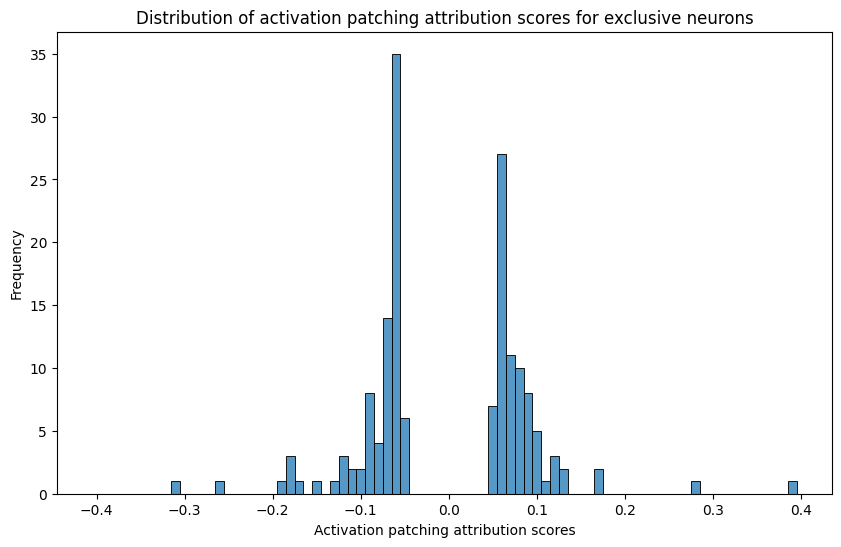

In [265]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.01
bins = np.arange(-0.4, 0.4 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

plt.figure(figsize=(10, 6))
sns.histplot(mlp_outlier_ap_scores, bins=bins, kde=False)
plt.title("Distribution of activation patching attribution scores for exclusive neurons")
plt.xlabel("Activation patching attribution scores")
plt.ylabel("Frequency")
plt.show()

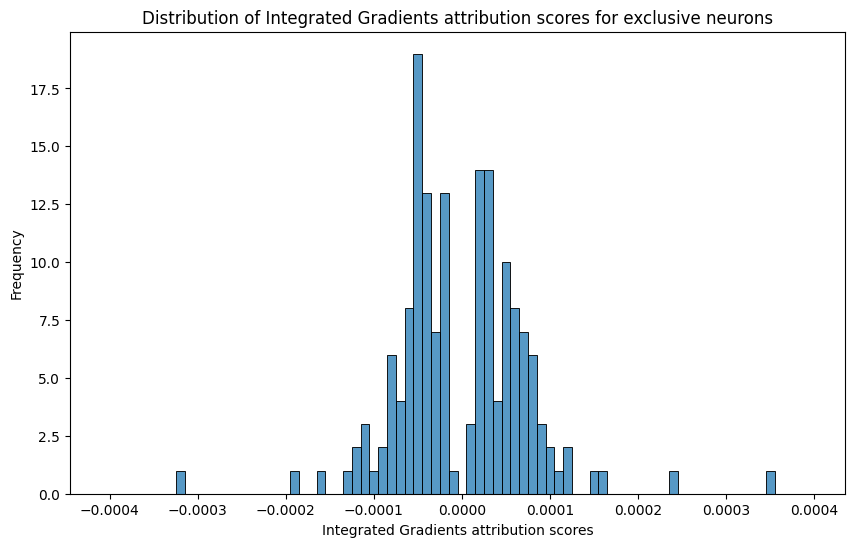

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 1e-5
bins = np.arange(-4e-4, 4e-4 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

plt.figure(figsize=(10, 6))
sns.histplot(mlp_outlier_ig_scores, bins=bins, kde=False)
plt.title("Distribution of Integrated Gradients attribution scores for exclusive neurons")
plt.xlabel("Integrated Gradients attribution scores")
plt.ylabel("Frequency")
plt.show()

In [109]:
# Integrated gradients scores for attention outliers
attn_outlier_ig_scores = []
attn_outlier_ap_scores = []

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]
        attn_outlier_ig_scores.append(ig_score.item())
        attn_outlier_ap_scores.append(ap_score.item())

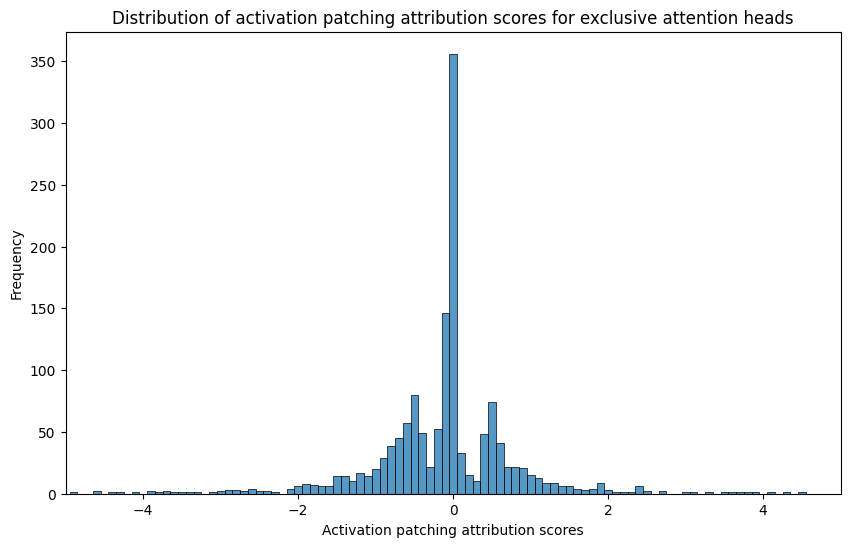

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.1
bins = np.arange(-5, 5 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

plt.figure(figsize=(10, 6))
sns.histplot(attn_outlier_ap_scores, bins=bins, kde=False)
plt.title("Distribution of activation patching attribution scores for exclusive attention heads")
plt.xlabel("Activation patching attribution scores")
plt.ylabel("Frequency")
plt.xlim(-5, 5)
plt.show()

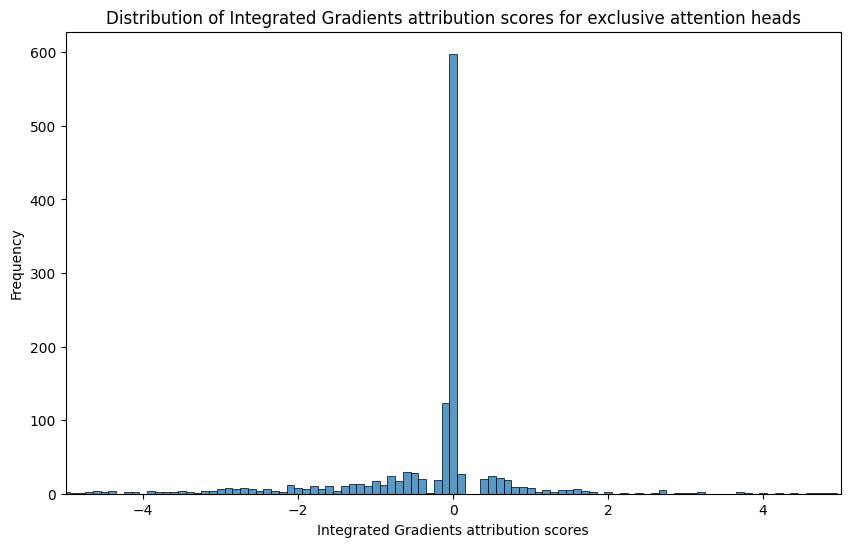

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.1
bins = np.arange(-5, 5 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

scaled_attn_outlier_ig_scores = [score * 1e5 for score in attn_outlier_ig_scores]  # Scale for better visualization

plt.figure(figsize=(10, 6))
sns.histplot(scaled_attn_outlier_ig_scores, bins=bins, kde=False)
plt.title("Distribution of Integrated Gradients attribution scores for exclusive attention heads")
plt.xlabel("Integrated Gradients attribution scores")
plt.ylabel("Frequency")
plt.xlim(-5, 5)
plt.show()

### Plot each distribution

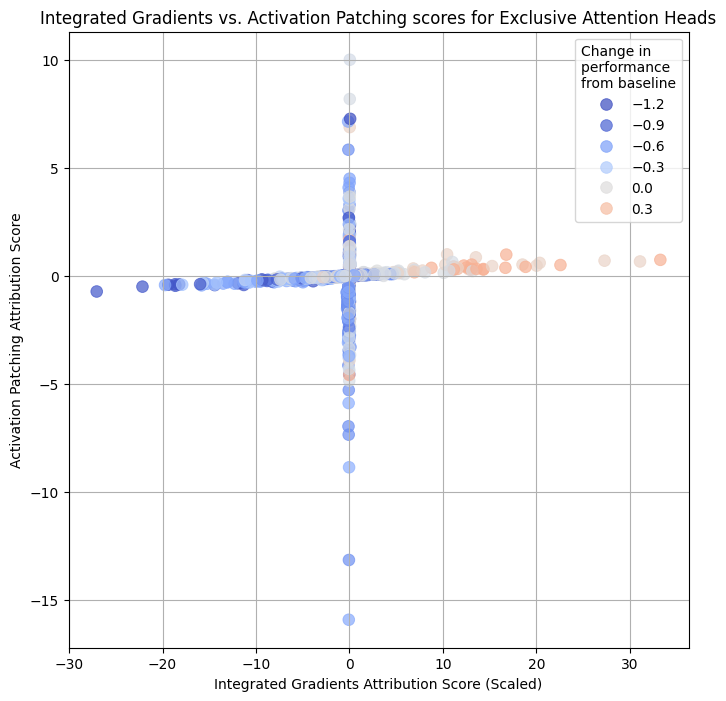

In [223]:
from matplotlib.colors import TwoSlopeNorm

# Plot IG vs AP score for attention head outliers
xs = []
ys = []
impact = []

for s, sample_attn_outlier_iso in enumerate(attn_outlier_iso):
    for layer, idx in sample_attn_outlier_iso.keys():
        ig_score = ig_attn[s, layer, idx]
        ap_score = ap_attn[s, layer, idx]

        xs.append(ig_score.item() * 1e5)
        ys.append(ap_score.item())
        change_in_performance = attn_outlier_iso[s][(layer, idx)] - 0.661 # baseline performance
        impact.append(change_in_performance)

plt.figure(figsize=(8, 8))

norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
sns.scatterplot(x=xs, y=ys, hue=impact, palette="coolwarm", hue_norm=norm, s=70, edgecolor=None, alpha=0.7)

plt.title("Integrated Gradients vs. Activation Patching scores for Exclusive Attention Heads")
plt.xlabel("Integrated Gradients Attribution Score (Scaled)")
plt.ylabel("Activation Patching Attribution Score")
plt.grid(True)
# plt.ylim(-30, 30)
# plt.xlim(-30, 30)
plt.legend(title="Change in \nperformance \nfrom baseline")
plt.show()

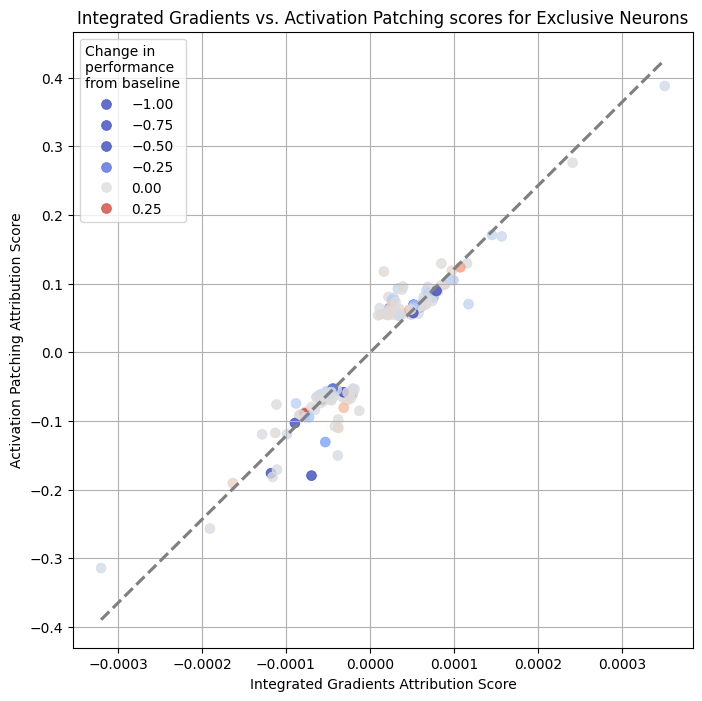

In [291]:
# Plot IG vs AP score for neuron outliers
xs = []
ys = []
impact = []

for s, sample_mlp_outlier_iso in enumerate(mlp_outlier_iso):
    for layer, idx in sample_mlp_outlier_iso.keys():
        ig_score = ig_mlp[s, layer, idx]
        ap_score = ap_mlp[s, layer, idx]

        xs.append(ig_score.item())
        ys.append(ap_score.item())
        change_in_performance = sample_mlp_outlier_iso[(layer, idx)] - 0.661 # baseline performance
        impact.append(change_in_performance)

plt.figure(figsize=(8, 8))

norm = TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.3)

sns.regplot(x=xs, y=ys, scatter=False, ci=None, color='gray', line_kws={'linestyle': '--'})
sns.scatterplot(x=xs, y=ys, hue=impact, palette="coolwarm", hue_norm=norm, edgecolor=None, s=50, alpha=0.8)

plt.title("Integrated Gradients vs. Activation Patching scores for Exclusive Neurons")
plt.xlabel("Integrated Gradients Attribution Score")
plt.ylabel("Activation Patching Attribution Score")
plt.grid(True)
# plt.ylim(-0.15, 0.15)
# plt.xlim(-4 * 1e-5, 4 * 1e-5)
plt.legend(title="Change in \nperformance \nfrom baseline")
plt.show()

### Plot overlapping distributions

In [254]:
max(mlp_outlier_ap_scores)

0.00035112129990011454

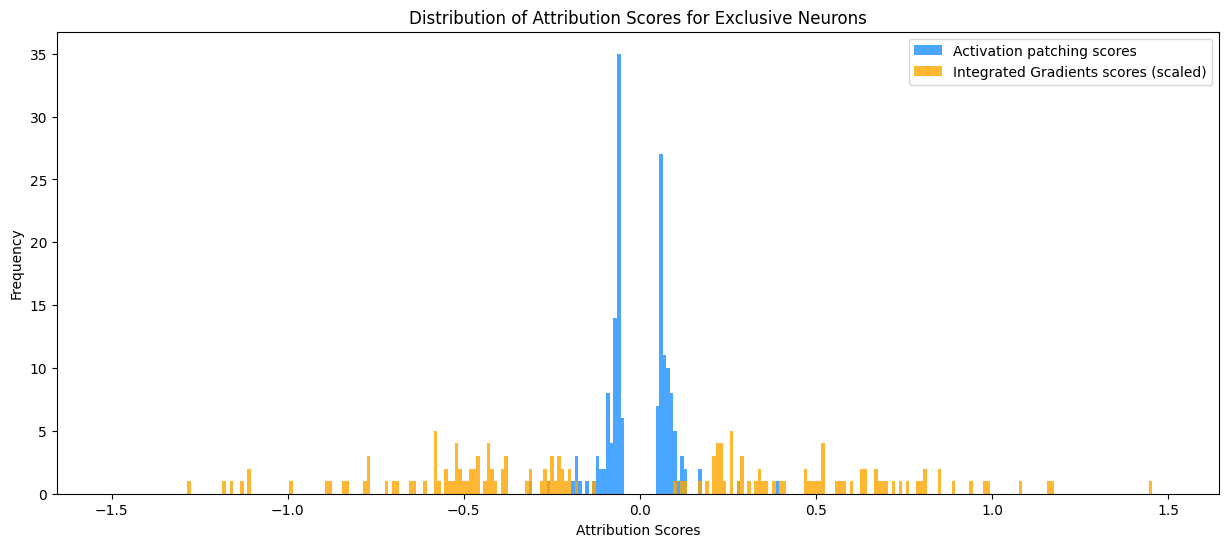

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.01
bins = np.arange(-1.5, 1.5 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

scaled_mlp_outlier_ig_scores = [score * 1e4 for score in mlp_outlier_ig_scores]

plt.figure(figsize=(15, 6))
sns.histplot(mlp_outlier_ap_scores, bins=bins, color='dodgerblue', edgecolor='none', alpha=0.8, label='Activation patching scores')
sns.histplot(scaled_mlp_outlier_ig_scores, bins=bins, color='orange', edgecolor='none', alpha=0.8, label='Integrated Gradients scores (scaled)')
plt.title("Distribution of Attribution Scores for Exclusive Neurons")
plt.xlabel("Attribution Scores")
plt.ylabel("Frequency")
plt.legend()
plt.show()

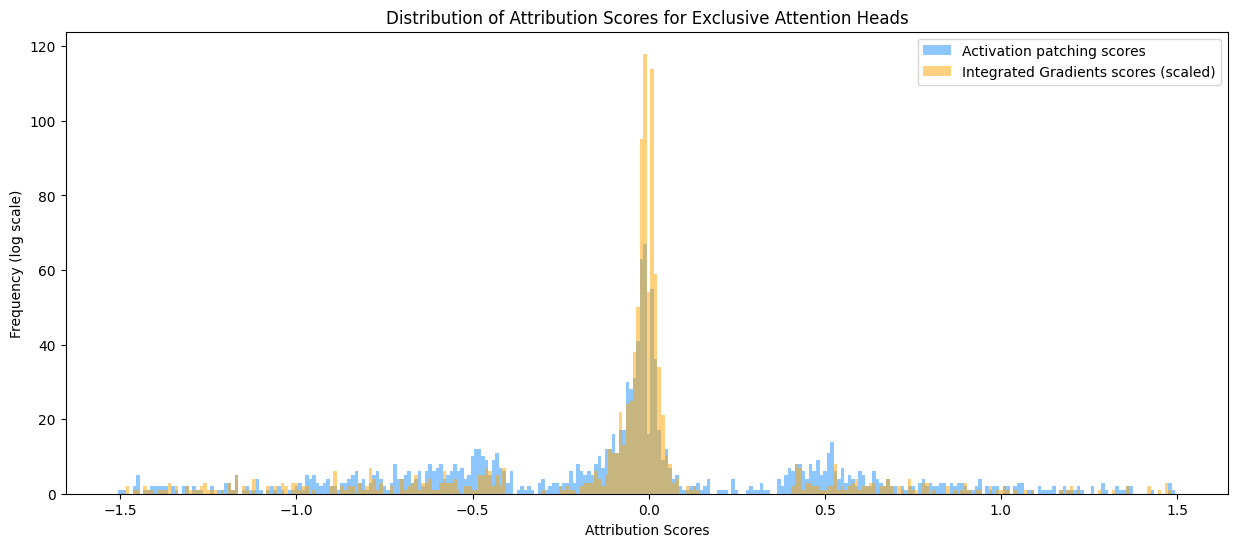

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

bin_width = 0.01
bins = np.arange(-1.5, 1.5 + bin_width, bin_width)
# Shift bins by half bin width to center them
bins = bins - bin_width / 2

plt.figure(figsize=(15, 6))
sns.histplot(attn_outlier_ap_scores, bins=bins, color='dodgerblue', edgecolor='none', alpha=0.5, label='Activation patching scores')
sns.histplot(scaled_attn_outlier_ig_scores, bins=bins, color='orange', edgecolor='none', alpha=0.5, label='Integrated Gradients scores (scaled)')
plt.title("Distribution of Attribution Scores for Exclusive Attention Heads")
plt.xlabel("Attribution Scores")
plt.ylabel("Frequency (log scale)")
# plt.yscale('log')
plt.legend()
plt.show()